Problem Statement -
Build your own recommendation system for products on an e-commerce website like Amazon.com.

Dataset Link - https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing

Dataset columns
first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.

Source
Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has several datasets. For this case study, we are using the Electronics dataset

Please do the analysis based on steps( 1 to 8) as given below -
Steps -



1.   Read and explore the given dataset. ( Rename column/add 
     headers, plot histograms, find data characteristics)
2.   Take a subset of the dataset to make it less sparse/ denser.  
    ( For example, keep the users only who has given 50 or more 
    number of ratings )
3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
4. Build Popularity Recommender model.
5. Build Collaborative Filtering model. Evaluate both the models. 
   ( Once the model is trained on the training data, it can be 
   used to compute the error (like RMSE) on predictions made on 
   the test data.) You can also use a 
  different method to evaluate the models.
6. Get top - K ( K = 5) recommendations. Since our goal is to 
   recommend new products to each user based on his/her habits, we 
   will recommend 5 new products.
7. summarise your insights.

Please Note -
1. If you are facing any memory issue while working on this 
  project, create a small subset (Let’s say 10% of data) and work 
  on it.
2.If you are stuck at the model evaluation part of this project.

In [0]:
# to ignore warning we can import warnings library 
import warnings
warnings.filterwarnings('ignore')

In [0]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [92]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:

# load dataset
df = pd.read_csv('/content/drive/My Drive/Recommanded/ratings_Electronics.csv', delimiter=",")

df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [0]:
# setting Collumns Header 
df.columns=['userid','productid','rating','timestamp']

In [95]:
# To see how our dataframe looks like 
df.head()

,userid,productid,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [96]:
# Understanding the datatype and number entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
userid       object
productid    object
rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [0]:
# As we dont need timestam we can drop it 
df = df.drop(['timestamp'],axis=1)

In [98]:
df.shape

(7824481, 3)

In [99]:
# Checking Nan values are present or not 
df.isna().sum()

userid       0
productid    0
rating       0
dtype: int64

In [100]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,7824481.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [101]:
# Fetting idea of unique values in our dataset 
for i  in df.columns:
    print ('Unique vlaues present in {} are : '.format(i),(df[i].nunique()))

Unique vlaues present in userid are :  4201696
Unique vlaues present in productid are :  476001
Unique vlaues present in rating are :  5


In [102]:
# counting frequency 
count = []
for i in df.columns:
    print ('valuse count for column {} is  ='.format(i) ,df[i].value_counts())
    count.append(df[i].value_counts().argmax())
count

valuse count for column userid is  = A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A24ZWMMJMJZO3C      1
A1VH0DX4F1B397      1
AVOR2JUYXTM5N       1
A1OZX8AIEWSJBN      1
A685IE6T73N78       1
Name: userid, Length: 4201696, dtype: int64
valuse count for column productid is  = B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B008O6IBVC        1
B008641P6K        1
B00004TZFZ        1
B005O1V8X8        1
B004HFVAZS        1
Name: productid, Length: 476001, dtype: int64
valuse count for column rating is  = 5.0    4347540
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64


['A5JLAU2ARJ0BO', 'B0074BW614', 5.0]

In [103]:
# getting idea about how mean rating of the products 
df.groupby('productid')['rating'].mean().head() 

productid
0321732944    5.000000
0439886341    1.666667
0511189877    4.500000
0528881469    2.851852
0558835155    3.000000
Name: rating, dtype: float64

In [104]:
# getting idea about how mean rating of the products are given by users 
df.groupby('productid')['rating'].mean().value_counts().head() 
# It gives idea about how many people have taken the product and rated the product 

5.0    131361
4.0     55055
3.0     35119
1.0     27894
4.5     18679
Name: rating, dtype: int64

In [105]:
# getting idea about how mean rating of the products are given by users and sorting the values 
df.groupby('productid')['rating'].count().sort_values(ascending=False).head()  

productid
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: rating, dtype: int64

In [106]:
# sorting the products rating 
df.groupby('productid')['rating'].mean().sort_values(ascending=False).head() 

productid
BT008V9J9U    5.0
B0058PRC0S    5.0
B0058ORBFU    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
Name: rating, dtype: float64

In [107]:
# getting an idea about count of each rating given by user 
df.groupby('rating').count()

,userid,productid
rating,,
1.0,901765,901765
2.0,456322,456322
3.0,633073,633073
4.0,1485781,1485781
5.0,4347540,4347540


#### Observing the distribution plot of rating 


In [0]:
# creating dataframe for plotting 
df_gp = df.groupby(by=['rating']).agg({'userid': 'count'}).reset_index()
df_gp.columns = ['Rating', 'Count']

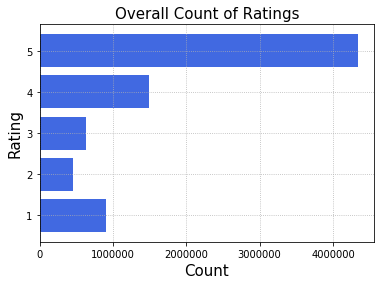

In [109]:
#ploting the axis label and ploting name 
plt.barh(df_gp.Rating, df_gp.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()

Q 2- Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

In [0]:
# keeping users only who has given 50 or more number of ratings 
# keeing count of rating of a user in count variable 
count = df.groupby('userid')['rating'].count()

In [111]:
# creating new dataframe in which we have only those users who have given 50 or more then 50 product
df_50_greater=df[df['userid'].isin(count[count > 50].index)]
df_50_greater['userid'].value_counts()# To cross check 

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
                 ... 
A2THQCHKR89E16     51
A3P69DTOXII004     51
A2HJY7418G1KV1     51
A303SNZ4AR7TDQ     51
A3AG5QAT8L0I3R     51
Name: userid, Length: 1466, dtype: int64

In [153]:
print(' all users :',df.shape)
print('who has given 50 or more number of ratings  :',df_50_greater.shape)

 all users : (7824481, 3)
who has given 50 or more number of ratings  : (122171, 3)


In [154]:
# observing the head of new datafram 
#ratings_mean_count= ratings_mean_count.reset_index(drop = False) # reseting the index
df_50_greater.head()

,userid,productid,rating
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
491,A3CLWR1UUZT6TG,0972683275,5.0
630,A3TAS1AG6FMBQW,0972683275,5.0


In [0]:
# Mean rating of each product is captured in 'ratings_mean_count'
ratings_mean_count = pd.DataFrame(df_50_greater.groupby('productid')['rating'].mean()) 

In [0]:
# Capturing number of user for each product who had given rating for that product in new column in 'ratings_mean_count'
ratings_mean_count['rating_counts'] =pd.DataFrame(df_50_greater.groupby('productid')['rating'].count())

In [116]:
ratings_mean_count= ratings_mean_count.reset_index(drop = False)
df_100_product= ratings_mean_count[ratings_mean_count['rating_counts'] >100]
df_100_product

,productid,rating,rating_counts
10820,B000N99BBC,4.773006,163
21486,B002R5AM7C,4.118110,127
21708,B002SZEOLG,4.287037,108
21954,B002V88HFE,4.702970,101
22850,B0034CL2ZI,4.628571,105
24262,B003ES5ZUU,4.858757,177
28121,B004CLYEDC,4.666667,117
30312,B004T9RR6I,3.870370,108
37407,B007WTAJTO,4.692308,156
37761,B00829THK0,4.409091,132


In [0]:
df_100_product_sorted = df_100_product.sort_values('rating',ascending=False)

In [118]:
# taking head from 'rating_mean_count' dataframe 
rec_count = df_100_product_sorted.head(10)
rec_count # recommended electronics product based on popularity 

,productid,rating,rating_counts
24262,B003ES5ZUU,4.858757,177
10820,B000N99BBC,4.773006,163
21954,B002V88HFE,4.702970,101
37407,B007WTAJTO,4.692308,156
28121,B004CLYEDC,4.666667,117
22850,B0034CL2ZI,4.628571,105
37803,B00834SJNA,4.495327,107
37765,B00829TIEK,4.431507,146
37761,B00829THK0,4.409091,132
21708,B002SZEOLG,4.287037,108


For popularity based recomendation system we recommend popular items which are also rated high

Its not clear if we just recommend the product based on high rating, we may missed on trending items

So it is important to take considreation of how many users had rated the product

So it is good if we select some threshold for products which are rated by minimum number of users

Trending product can be recommended if we consider timestamp but we are ignoring that in this case

We are selecting those products which are rated by atleast 100 user

In [119]:
ratings_mean_count.groupby('productid')['rating'].mean().sort_values(ascending=False).head()

productid
B00LKG1MC8    5.0
B000H8WLKC    5.0
B000HA4EZK    5.0
B004EHZZDW    5.0
B004EI0EG4    5.0
Name: rating, dtype: float64

In [0]:
!pip install -q surprise

In [0]:
# Importing Surprise library pakages 
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [0]:
# As we're loading a custom dataset, we need to define a reader. In the
# ratings_Electronics.csv dataset, each line has the following format:
# 'user item rating ', separated by ',' characters.
reader = Reader(line_format='user item rating ', sep=',',rating_scale=(1, 5))

In [0]:
# Loading the data into surprise library object
data = Dataset.load_from_df(df_50_greater[['userid', 'productid', 'rating']], reader)

In [124]:
# tring to observe the data , but its is in surprise.dataset
data


**Q-3 Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)**

In [0]:
# Spliting the data into train and test 
trainset, testset = train_test_split(data, test_size=.3)

In [0]:
#Importing SVD from Surprise
from surprise import SVD
#importing gridsearchcv fro parameter tunning 
from surprise.model_selection import GridSearchCV

In [0]:
# defining Parameter Grid 
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

#Instantiating gridsearchcv object
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
# fitting data into the object  
gs.fit(data)

>- n_epochs – The number of iteration of the SGD procedure. Default is 20.
>- lr_all – The learning rate for all parameters. Default is 0.005.
>- reg_all – The regularization term for all parameters. Default is 0.02.

In [128]:
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9862944603471805
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [0]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator['rmse']
trainingSet = data.build_full_trainset()
trainingSet = algo.fit(trainingSet)

In [0]:
# stroring the results of gridSearch Cv in results_df
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [131]:
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,1.012163,1.014910,1.016327,1.014467,0.001729,7,0.776151,0.780076,0.782131,0.779453,0.002481,7,1.406727,0.019017,0.357436,0.110684,"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}",5,0.002,0.4
1,1.012793,1.015295,1.017378,1.015155,0.001874,8,0.777727,0.781397,0.783682,0.780935,0.002453,8,1.430077,0.020850,0.347901,0.099168,"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.6}",5,0.002,0.6
2,0.993121,0.995881,0.996802,0.995268,0.001564,3,0.752549,0.757623,0.758875,0.756349,0.002735,3,1.401006,0.023131,0.349669,0.099799,"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.4}",5,0.005,0.4
3,0.995469,0.998578,0.998995,0.997681,0.001573,4,0.756983,0.761507,0.762876,0.760456,0.002518,4,1.375391,0.020066,0.338485,0.095948,"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.6}",5,0.005,0.6
4,0.997140,1.000299,1.000972,0.999470,0.001670,5,0.757841,0.762986,0.764149,0.761658,0.002741,5,2.693375,0.061277,0.354478,0.100064,"{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.4}",10,0.002,0.4


In [0]:
# Predicting the values on testset

predictions = algo.test(testset)

In [133]:
# checking the accuracy 
accuracy.rmse(predictions, verbose=True)

RMSE: 0.9049


0.9049205848887796

In [134]:
# Understanding and printing the prediction 
predictions

[Prediction(uid='A2Y739CRM15WDL', iid='B0042FZ50O', r_ui=5.0, est=4.078560344245093, details={'was_impossible': False}),
 Prediction(uid='ALNE7Q71JFC0F', iid='B00022KOWU', r_ui=1.0, est=3.5648960460139527, details={'was_impossible': False}),
 Prediction(uid='ABQWMANK4AR63', iid='B007GJ4GFS', r_ui=2.0, est=3.9370626473988968, details={'was_impossible': False}),
 Prediction(uid='A1WF4QNIE2Z3I7', iid='B00B728JY4', r_ui=5.0, est=4.39749854597169, details={'was_impossible': False}),
 Prediction(uid='A1UTM65Y3G9HUL', iid='B005XULTG6', r_ui=3.0, est=4.050324505420431, details={'was_impossible': False}),
 Prediction(uid='A1CST2WUA32GP0', iid='B000VRL632', r_ui=4.0, est=4.0598080898402555, details={'was_impossible': False}),
 Prediction(uid='AK9BXHEXOOM6Z', iid='B005O81U9S', r_ui=5.0, est=4.432813288925001, details={'was_impossible': False}),
 Prediction(uid='A1J87SYB3JPQWH', iid='B0009XQPJ8', r_ui=5.0, est=4.60963722868424, details={'was_impossible': False}),
 Prediction(uid='A3IOQ7NVVLAUEE', 

In [0]:
from collections import defaultdict
def get_top_n(predictions,n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [0]:
# Genrating top 5 recommendation for user 
top_n = get_top_n(predictions, n= 5) 

In [0]:
# Print the recommended items for each user
user_list= []
for uid, user_ratings in top_n.items():
    single_user= (uid, [iid for (iid, _) in user_ratings])
    user_list.append(single_user)

In [0]:
recommendation_for_user = pd.DataFrame(user_list,columns=['userid','recommended electronics_id'])

In [139]:
# all recommendations for user
recommendation_for_user

,userid,recommended electronics_id
0,A2Y739CRM15WDL,"[B000V9NU2A, B00829THK0, B008F537KC, B0046HAO4..."
1,ALNE7Q71JFC0F,"[B002V8C3W2, B00006I5J7, B002Y6CJJ8, B0076AYNX..."
2,ABQWMANK4AR63,"[B003ES5ZUU, B002YU83YO, B006EKIQYM, B00622AG6..."
3,A1WF4QNIE2Z3I7,"[B00BQ4F9ZA, B0099SMFVQ, B000S5Q9CA, B0048IW03..."
4,A1UTM65Y3G9HUL,"[B007SZ0E1K, B009NHAEXE, B00746W3HG, B008AST7R..."
...,...,...
1461,A2E1EFNIZL2FVA,"[B002TLTE6O, B003VANO7C, B003LVZO88, B00HRQB28..."
1462,A24QFMD1RXLJMB,"[B001TH7GUK, B00007IFED, B002K3Z3DO, B003TSCZV..."
1463,A1NZLRAZJGD99W,"[B0019EHU8G, B00181BHRK, B00005N6KG, B0090SLE3..."
1464,A240FRPD4MEXND,"[B002VPE1X4, B004GUT1QO, B00GO1UV4E, B00966PFH..."


In [0]:
def rec_5 (user_id):
    return recommendation_for_user[recommendation_for_user['userid']== user_id]['recommended electronics_id'].tolist()

In [0]:
user_id = 'A1NMM0RDRF6R84'

In [142]:
rec_5(user_id)

[['B0040JHVC2', 'B004WB8EYM', 'B00007IFED', 'B002J9HBIO', 'B000GUHOYE']]

In [0]:
# Getting all the products rated by given user 
product_id_check = df_50_greater[df_50_greater['userid']== 'A1NMM0RDRF6R84']

In [144]:
# checking the recommended product exist in user rating history or not  
product_id_check[product_id_check['productid']== 'B000HZ9CCA' ]

,userid,productid,rating
1015882,A1NMM0RDRF6R84,B000HZ9CCA,3.0


>- It is observed that we are not able to recommendan any new electronic product 


In [0]:
reco_list= ['B000QUUFRW', 'B0040JHVC2', 'B00007IFED', 'B004WB8EYM', 'B002J9HBIO']

In [146]:
set(reco_list) - set(product_id_check['productid']) 

set()

>- As we can observe that set is empty which gives us clear idea that no new electronic items were recommended new 

In [0]:
## Creating Dataframe from predictions to fetch new products
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_pred['Iu'] = df_pred.uid.apply(get_Iu)
df_pred['Ui'] = df_pred.iid.apply(get_Ui)
df_pred['err'] = abs(df_pred.est - df_pred.rui)
best_predictions = df_pred.sort_values(by='err')[:]
#worst_predictions = df_pred.sort_values(by='err')[-10:]

In [148]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
20918,A10O7THJ2O20AG,B000QUUFRW,5.0,5.000000,{'was_impossible': False},51,55,0.000000
28467,A1XXMNLOLKNO0I,B0000BZL1P,5.0,5.000000,{'was_impossible': False},81,30,0.000000
14729,A11ULAZ4B5ZXC8,B000IJY8DS,5.0,5.000000,{'was_impossible': False},42,9,0.000000
19685,A2TN0U8173HM7A,B000BQ7GW8,5.0,5.000000,{'was_impossible': False},44,37,0.000000
22196,A2HDTOF8222KN3,B003ES5ZUU,5.0,5.000000,{'was_impossible': False},47,115,0.000000
...,...,...,...,...,...,...,...,...
1637,AHF4I1FSIHABC,B00007E7JU,1.0,4.603266,{'was_impossible': False},43,37,3.603266
27546,A3V8P0O224OBDB,B0002L5R78,1.0,4.676559,{'was_impossible': False},44,46,3.676559
13759,A9BWUH9XKZ2DQ,B00006RVPW,1.0,4.691406,{'was_impossible': False},35,23,3.691406
3687,A1H55L0BLPCWYF,B0002L5R78,1.0,4.813980,{'was_impossible': False},38,46,3.813980


In [0]:
def  recomendation (uid):
    # Finding those product which are not rated by user
    not_rated_items_byUser =pd.DataFrame(list(set(best_predictions['iid']) - 
                                              set(best_predictions[best_predictions['uid'] == uid]['iid']))
                                              ,columns= ['prod_id'])
    # creating New dataframe which consist of only those electronic item which are not rated by user
    Items_to_be_recommended_from = best_predictions[best_predictions['iid'].isin(not_rated_items_byUser['prod_id'])]
    # sorting electronic product in ascending order and slecting top 5 products as a recomendation to a perticular user
    top_5_recommendation = ((Items_to_be_recommended_from.sort_values('est',na_position='first'
                                                                      ,ascending=False))[['iid','est']]).iloc[:5]
    return top_5_recommendation

In [150]:
# Recommendation for a given user 
recomendation('A3CKI6VEH0HBMJ')

,iid,est
20918,B000QUUFRW,5.0
32551,B000CKVOOY,5.0
11389,B0052SCU8U,5.0
24813,B007WTAJTO,5.0
17309,B0052SCU8U,5.0
